# MRT analysis:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%ls rov-mrt/
!head rov-mrt/forward/rcc06-bview.20170124.0800.gz.csv

analyze.py      downloadrouteviews.sh  gencsv.py
downloadris.sh  forward/               reverse/
prefix,src_peer,aspath
188.227.158.0/24,5,"['2497', '6939', '29134']"
188.227.158.0/24,8,"['25152', '6939', '29134']"
188.227.159.0/24,5,"['2497', '2603', '21320', '378']"
188.227.159.0/24,8,"['25152', '6939', '21320', '378']"


In [10]:
import os

rov_forward = {'188.227.158.0/24': 29134, '188.227.159.0/24': 378}
rov_reverse = {'188.227.158.0/24': 378, '188.227.159.0/24': 29134}


def is_valid(prefix, aspath, rov_vector):
    if not prefix in rov_vector:
        return 0
    if rov_vector[prefix] == aspath[-1]:
        return 1
    else:
        return -1

def select_valid(csvdf, rov_vector):
    return csvdf.apply(lambda row: is_valid(row['prefix'], get_aspath(row['aspath']), rov_vector), axis=1)

def get_aspath(pylist):
    return [int(asn) for asn in eval(pylist)]

def analyze(path, rov_table):
    asn = {}
    for csvfn in os.listdir(path):
        df = pd.read_csv(path+csvfn)
        if df.empty:
            continue
        df['status'] = select_valid(df, rov_table)
        for i,r in df.iterrows():
            for a in get_aspath(r['aspath']):
                if a in asn:
                    asn[a].add(r['status'])
                else:
                    asn[a] = {r['status']}
    return asn

def count_rows(path):
    res=0
    for csvfn in os.listdir(path):
        df = pd.read_csv(path+csvfn)
        if df.empty:
            continue
        res+=df.shape[0]
    return res

f=analyze('rov-mrt/forward/', rov_forward)
r=analyze('rov-mrt/reverse/', rov_reverse)

def cmp(x, y):
    for asn in set(x.keys()) | set(y.keys()):
        yield (asn, (x[asn] if asn in x else set()) | (y[asn] if asn in y else set()))

def find_rov(x,y):
    res = dict(cmp(x,y))
    for k in res.keys():
        if res[k] == {1}:
            yield k
        
rov=set(find_rov(f,r))
print(str(rov))


print("rov_possible=%d all=%d"%(len(rov),len(f)))

print("count forward: %d" % count_rows('rov-mrt/forward/'))
print("count reverse: %d" % count_rows('rov-mrt/reverse/'))


{28929, 20485, 6663, 37640, 29449, 263945, 25227, 13703, 32653, 52752, 4755, 52888, 4635, 8220, 39326, 20771, 262317, 9902, 16559, 37680, 202032, 327984, 24115, 34224, 53171, 3130, 37179, 50620, 262589, 59715, 3269, 5580, 13647, 4436, 8283, 43100, 52320, 37474, 1251, 263651, 8422, 51945, 8943, 263152, 14840, 24441}
rov_possible=46 all=296
count forward: 730
count reverse: 696


In [5]:
def analyze_strict(path, rov_table, factor):
    asn = {}
    rk = list(rov_table.keys())
    keys = {rk[0]:0, rk[1]:1}
        
    def gen_factor(status, prefix, factor):
        if prefix in keys:
            res =  [0, 0, 0, 0]
            res[keys[prefix]+factor] = status
            return tuple(res)
        else:
            return tuple(0)
    
    for csvfn in os.listdir(path):
        df = pd.read_csv(path+csvfn)
        if df.empty:
            continue
        df['status'] = select_valid(df, rov_table)
        for i,r in df.iterrows():
            for a in get_aspath(r['aspath']):
                if a in asn:
                    asn[a].add(gen_factor(r['status'], r['prefix'], factor))
                else:
                    asn[a] = set()
                    asn[a].add(gen_factor(r['status'], r['prefix'], factor))
    return asn

f=analyze_strict('rov-mrt/forward/', rov_forward, 0)
r=analyze_strict('rov-mrt/reverse/', rov_reverse, 2)

def rank_rov(x, y):
    def rank(row):
        res = [0, 0, 0 ,0]
        for vect in row:
            for i,v in enumerate(vect):
                if v < 0:
                    return -1
                if v == 1:
                    res[i] = 1

        if (res[0] or res[1]) and (res[2] or res[3]):
            return 2
        return 0
    
    res = dict(cmp(x,y))
    for k in res.keys():
        r = rank(res[k])
        if r > 0:
            yield (k, r)

rov=set(rank_rov(f,r))
print(str(rov))
        
print("rov=%d all=%d"%(len(rov),len(f)))

{(8283, 2), (3269, 2), (59715, 2), (3130, 2)}
rov=4 all=296


In [6]:
def find_aspath(path):
    for csvfn in os.listdir(path):
        df = pd.read_csv(path+csvfn)
        if df.empty:
            continue
        for i,row in df.iterrows():
            for asn,rand in rov:
                if asn in get_aspath(row['aspath']):
                    print(str(asn)+" "+row['aspath'])
                    
find_aspath('rov-mrt/forward/')
find_aspath('rov-mrt/reverse/')

8283 ['8283', '6939', '29134']
3130 ['3130', '1239', '6939', '29134']
3130 ['3130', '1239', '6939', '29134']
3269 ['59715', '3269', '6762', '6939', '29134']
59715 ['59715', '3269', '6762', '6939', '29134']
3130 ['3130', '1239', '3356', '5588', '29134']
3130 ['3130', '1239', '3356', '5588', '29134']
8283 ['8283', '2603', '21320', '378']
8283 ['8283', '3356', '5588', '29134']
59715 ['59715', '29449', '174', '21320', '378']
3269 ['59715', '3269', '6762', '3356', '5588', '29134']
59715 ['59715', '3269', '6762', '3356', '5588', '29134']


# RIPE Atlas analysis

In [ ]:
import sys, os
if not 'rov-atlas' in sys.path:
    sys.path.append('rov-atlas')
if 'defcompare_results_traceroute' in sys.modules:
    del compare_results_traceroute
import compare_results_traceroute

os.chdir('rov-atlas')
compare_results_traceroute.main()
os.chdir('..')

pair (7934009, 7934010) same=106 diff=31 incomplete=0
pair (7934022, 7934023) same=819 diff=77 incomplete=13
pair (7937437, 7937438) same=958 diff=18 incomplete=7
pair (7942364, 7942365) same=967 diff=13 incomplete=7
pair (7942381, 7942382) same=957 diff=19 incomplete=7
pair (7942396, 7942397) same=957 diff=23 incomplete=8
pair (7942403, 7942404) same=192 diff=1 incomplete=2
pair (7942411, 7942412) same=133 diff=3 incomplete=0
pair (7942417, 7942418) same=869 diff=33 incomplete=4
pair (7942692, 7942693) same=870 diff=31 incomplete=3
pair (7943542, 7943543) same=960 diff=15 incomplete=9
pair (7943548, 7943549) same=964 diff=18 incomplete=5
ROV affected probes:
[12302, 28694, 12894, 12917, 29575, 25752, 18091, 26315, 26346, 6255, 14623, 12089, 12280, 24999, 30407, 30476, 18304, 10667, 31475, 3528, 28528, 4981, 30333, 6097, 6208, 23083, 15020, 19457, 19481, 16701, 21414, 29774, 26925, 31578, 31842, 11619, 15869, 12223, 19201, 26328, 138, 357, 433, 472, 586, 588, 747, 792, 1029, 1359, 1504

In [ ]:
# 12 probable ROV ASNs, 2 manually verified - argentina & randy

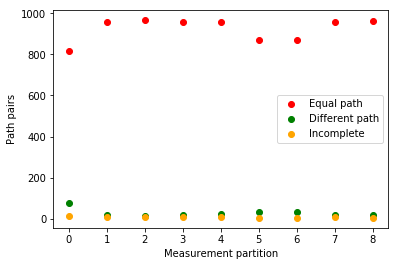

In [3]:
same1 = [819, 958, 967, 957, 957, 869, 870, 960, 964]
diff1 = [77, 18, 13, 19, 23, 33, 31, 15, 18]
incomp1 = [13, 7, 7, 7, 8, 4, 3, 9, 5]

plt.plot(same1, 'o', label='Equal path', color='red')
plt.plot(diff1, 'o', label='Different path', color='green')
plt.plot(incomp1, 'o', label='Incomplete', color='orange')
plt.legend()
plt.xlabel('Measurement partition')
plt.ylabel('Path pairs')
plt.savefig('atlas-noise.eps', format='eps', dpi=1000)
plt.show()

# TCP capture experiment:

Using the >=3 distinct ROV-compliant hits in the rounds. (= this is basically upper bound)
It takes few hours to finish the computations, so here are only the results using the last measurement round:

```
brill@tapir:~/ownCloud/rov/rov-tcp$ python analyzeexperiment.py 
Opening file cz/trace_20170626-145623.pcap
Opening file cz/trace_20170627-145628.pcap
Opening file il/trace_20170626-132057.pcap
Opening file il/trace_20170627-132100.pcap
Opening file cz/trace_20170623-222737.pcap
Opening file cz/trace_20170624-214611.pcap
Opening file cz/trace_20170625-214611.pcap
Opening file il/trace_20170623-131652.pcap
Opening file il/trace_20170624-131652.pcap
Opening file il/trace_20170625-131945.pcap

rov=201 norov=632570 unknown=45163 mismatch=0
```

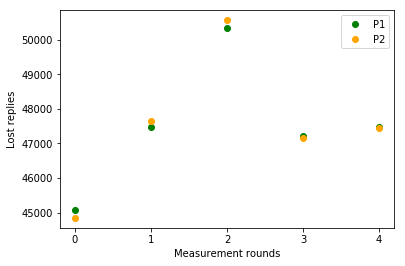

In [4]:
#x['il/trace_20170625-131945.pcap']=(161871, 212, 163012, 204)
#x['cz/trace_20170625-214611.pcap']=(465714, 1511, 464355, 1519)
#x['il/trace_20170624-131652.pcap']=(162650, 291, 163763, 300)
#x['il/trace_20170626-132057.pcap']=(163037, 406, 162123, 383)
#x['il/trace_20170627-132100.pcap']=(163112, 396, 162138, 385)
#x['il/trace_20170623-131652.pcap']=(164068, 432, 165447, 442)
#x['cz/trace_20170624-214611.pcap']=(467811, 5970, 466507, 5783)
#x['cz/trace_20170627-145628.pcap']=(467351, 7429, 468338, 7527)
#x['cz/trace_20170626-145623.pcap']=(467681, 7269, 468654, 7385)
#x['cz/trace_20170623-222737.pcap']=(468794, 7564, 467643, 7515)


il=[(164068, 432, 165447, 442), (162650, 291, 163763, 300), (161871, 212, 163012, 204), (163037, 406, 162123, 383), (163112, 396, 162138, 385)]
cz=[(468794, 7564, 467643, 7515), (467811, 5970, 466507, 5783), (465714, 1511, 464355, 1519), (467681, 7269, 468654, 7385), (467351, 7429, 468338, 7527)]

hit1=[]
hit2=[]
mis1=[]
mis2=[]
for i in range(0, len(cz)):
    hit1.append(cz[i][0]+il[i][0])
    hit2.append(cz[i][2]+il[i][2])
    mis1.append(cz[i][1]+il[i][1])
    mis2.append(cz[i][3]+il[i][3])

#632570+45163+201=677934
    
loss1 = [677934 - h for (h,m) in zip(hit1,mis1)]
loss2 = [677934 - h for (h,m) in zip(hit2,mis2)]

fig, ax = plt.subplots()
#plt.plot(hit1, '.', label='P1 reply received', color='blue')
plt.plot(loss1, 'o', label='P1', color='green')
#plt.plot(mis1, '.', label='P1 mismatch', color='red')
#plt.plot(hit2, '+', label='P2 reply received', color='green')
plt.plot(loss2, 'o', label='P2', color='orange')
#plt.plot(mis2, '+', label='P2 mismatch', color='orange')

plt.legend()
plt.xlabel('Measurement rounds')
plt.ylabel('Lost replies')
ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(('Control plane', 'Atlas', 'TCP probes'))

plt.savefig('capnoise.eps', format='eps', dpi=1000)
plt.show()

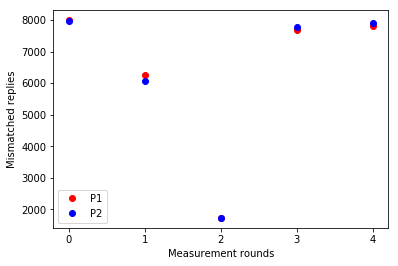

In [5]:
fig, ax = plt.subplots()
#plt.plot(hit1, '.', label='P1 reply received', color='blue')
#plt.plot(loss1, '.', label='P1 loss')
plt.plot(mis1, 'o', label='P1', color='red')
#plt.plot(hit2, '+', label='P2 reply received', color='green')
#plt.plot(loss2, '+', label='P2 loss')
plt.plot(mis2, 'o', label='P2', color='blue')

plt.legend()
plt.xlabel('Measurement rounds')
plt.ylabel('Mismatched replies')
ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(('Control plane', 'Atlas', 'TCP probes'))

plt.savefig('capnoise2.eps', format='eps', dpi=1000)
plt.show()

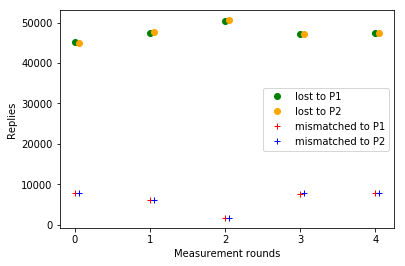

In [22]:
fig, ax = plt.subplots()
plt.plot([0,1,2,3,4], loss1, 'o', label='lost to P1', color='green')
plt.plot([0.05,1.05,2.05,3.05,4.05], loss2, 'o', label='lost to P2', color='orange')
plt.plot([0,1,2,3,4], mis1, '+', label='mismatched to P1', color='red')
plt.plot([0.05,1.05,2.05,3.05,4.05], mis2, '+', label='mismatched to P2', color='blue')
plt.legend()
plt.xlabel('Measurement rounds')
plt.ylabel('Replies')
ax.set_xticks([0,1,2,3,4])

plt.savefig('combinednoise.eps', format='eps', dpi=1000)
plt.show()

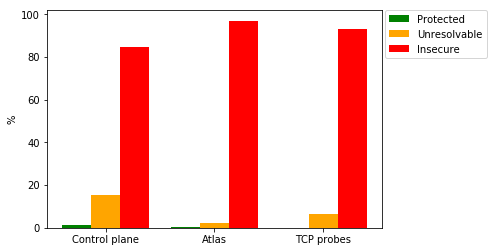

In [5]:
import numpy as np

# just copy values from previous experiments
norov = [84.5, 97.0, 93.30]
rov = [1.35, 0.5, 0.03]
unk = [15.5, 2.3, 6.66]

width=0.2
ind = np.arange(len(norov))*0.75

fig, ax = plt.subplots()
plt.bar(ind, rov, width, label='Protected', color='green')
plt.bar(ind+width, unk, width, label='Unresolvable', color='orange')
plt.bar(ind+width*2, norov, width, label='Insecure', color='red')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('')
plt.ylabel('%')
#plt.yscale('log')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Control plane', 'Atlas', 'TCP probes'))
plt.savefig('comparison.eps', format='eps', dpi=1000, bbox_inches = 'tight')
plt.show()

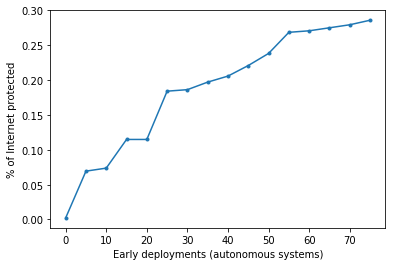

In [18]:
# this is a basic (randomized) simulation, real simulator is needed!!!

import random

extrapolate=False
custlist='AS_customers.txt'

rovconfirm={3130, 59715}
rovlikely={28929, 20485, 6663, 37640, 29449, 263945, 25227, 13703, 32653, 52752, 4755, 52888, 4635, 8220,
           39326, 20771, 262317, 9902, 16559, 37680, 202032, 327984, 24115, 34224, 53171, 3130, 37179, 50620,
           262589, 59715, 3269, 5580, 13647, 4436, 8283, 43100, 52320, 37474, 1251, 263651, 8422, 51945, 8943,
           263152, 14840, 24441, 29571, 3130, 8612, 25543, 11815, 49770, 34154, 34549, 197207, 20794, 8283, 62078}

# the last line has been added form Atlas measurements

def read_aslist(f):
    with open(f, 'r') as fd:
        for l in fd:
            ls = l.split()
            try:
                yield (int(ls[0]), int(ls[1]))
            except:
                pass


def normalize(n):
    if n < 3:
        return 0
    if n < 20:
        return 1
    return int(n/20)
            
def resolve(rovlist, asdict):
    result=1
    for m in rovlist:
        if m in asdict:
            result+=normalize(asdict[m])
    return 100*float(result)/(len(asdict.keys()))

def sort_size(aslist, asdict):
    #s = sorted(aslist, key=lambda x: asdict[x] if x in asdict else 0)[:-5]
    #l=int(len(s)/4)
    #return s[0:l] + s[3*l:4*l] + s[2*l:3*l:-1] + s[l:2*l]
    return aslist

def gen():
    asdict = dict(read_aslist(custlist))
    adopt=[]
    x=[]
    y=[]
    
    x.append(len(adopt))
    y.append(resolve(adopt, asdict))
    projection = {list(asdict.keys())[i] for i in [random.randrange(0, len(asdict.keys())) for r in range(0,20)]}
    for m in sort_size(rovconfirm|rovlikely|projection, asdict):
        adopt.append(m)
        x.append(len(adopt))
        y.append(resolve(adopt, asdict))
        
    plt.plot(x[::5], y[::5], ".-")
    plt.xlabel('Early deployments (autonomous systems)')
    plt.ylabel('% of Internet protected')
    #plt.annotate('current status', xy=(2, 0.03), xytext=(3, 0.2), arrowprops={'facecolor':'black', 'shrink':0.05})
    plt.savefig('rovimp.eps', format='eps', dpi=1000)
    plt.show()

#    for i in range(1,100):
#	for s in range(step):
#        	mi = random.randint(200,len(asdict.keys())-1)
#        	m = asdict.keys()[mi]
#        	adopt.append(m)
#        print '%d %f' % (len(adopt), resolve(adopt, asdict))


gen()